In [1]:
import cv2 as cv
import numpy as np
import sklearn as skl
import scipy as cp
import matplotlib.pyplot as plt
import tensorflow as tf
#import torch as pt
import os
import csv
import sys
import pandas as pd
from sklearn import tree
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn import manifold, neighbors, metrics
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA

C:\Users\Tabea\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Tabea\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Tabea\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Tabea\AppData\Roaming\Python\Python37\site-

In [2]:
### Dictionaries for labeling data from images
def retrieveDict(nr):
    if nr == 0:
        dictionary = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26}
    elif nr == 1:
        dictionary = {'A':0,'B':1,'C':2,'D':3,'E':4,'F':5,'G':6,'H':7,'I':8,'J':9,'K':10,'L':11,'M':12,
                   'N':13,'O':14,'P':15,'Q':16,'R':17,'S':18,'T':19,'U':20,'V':21,'W':22,'X':23,'Y':24,
                   'Z':25,'space':26,'del':27,'nothing':28}
    else:
        print("No valid dictionary found")
        dictionary = -1
    
    return dictionary

In [38]:
### Data reading functions

def readDataFolder(path, dictionary, oneHot,rescaleSize):
    '''read data from different folders
        data location: .../path/
        labels assigned from dictionary default A = 1, B = 2 etc
        oneHot determines if labels are made binary i.e. A =[1,0,...], B=[0,1,...] etc
        returns data, rescaled to rescaleSize,rescaleSize and labels as numpy arrays
        '''
    data = []
    labels = []
    size = rescaleSize,rescaleSize
    
    f =['A', 'B', 'C', 'E']
    for folder in f:
        print(folder, end = ' | ')
        for image in os.listdir(path + os.sep + folder):
            img = cv.imread(path + os.sep + folder + os.sep + image)
            img = cv.resize(img,size)
            data.append(img)
            labels.append(dictionary[folder])
    data = np.array(data)
    data = data.astype('float32')/255.0
    
    
    
    labels = np.array(labels)
    
    return data, labels

def readCSV(path, rescaleSize):
    '''read data from csv file
        data location: .../path/
        returns data, rescaled to rescaleSize,rescaleSize, and labels as numpy arrays
        '''
    size = rescaleSize,rescaleSize
    data = []
    train = pd.read_csv(path)
    labels = train['label'].values
    unique_val = np.array(labels)
    np.unique(unique_val)
    
    train.drop('label', axis = 1, inplace = True)
    images = train.values
 
    for i in range(len(images)):
        img = images[i].reshape(28,28)
        img = cv.resize(img.astype('uint8'),size)
        data.append(img)
    data = np.array(data)
    data = data.astype('float32')/255.0
    
    return data, labels

In [12]:
### Different PreProcessing methods

def preprocessing(method, data, size, parameters, dataset):
    '''
        Applies preprocessing to data  
    '''
    # Parameters
    gaussianKernel = parameters[0]
    gaussianMean = parameters[1]
    structElement = np.ones((parameters[2],parameters[2]),np.uint8)
    cannyKernel = parameters[3]
    lowThreshold = parameters[4]
    highThreshold = parameters[5]
    
    
    if method[0] == 1:
        print("Not implemented, Doing Gamma Correction")
                       
    if method[1] == 1:
        print("Gaussian Denoising")
        data = gaussianDenoise(data, gaussianKernel, gaussianMean, size)
        
    if method[2] == 1:
        print("Converting to grayscale")
        data = grayScale(data)
        
    if method[3] == 1:
        print("Canny Edge detection")
        data = cannyEdgeDetection(data,lowThreshold,highThreshold,cannyKernel)
        
    if method[4] == 1:
        print("Segmentation, background/foreground")     
        data = segmentation(data,structElement, method[2], dataset)
        
    if method[5] == 1:
        print("Sobel Filtering")
        data = sobelFilter(data)
        
    if method[6] == 1:
        print("Performing opening")
        data = opening(data,structElement)
    
    return data
    

def cannyEdgeDetection(inData, lowThreshold,highThreshold, kernelSize):
    data = []
    for i in range(len(inData)):
        cannyEdges = cv.Canny(inData[i].astype("uint8"), lowThreshold, highThreshold, kernelSize)
        data.append(cannyEdges)
    data = np.array(data)
    return data
  
def grayscale(inData):
    data = []
    for i in range(len(inData)):
        gray = cv.cvtColor(inData[i]*255, cv.COLOR_RGB2GRAY).astype("uint8") #Convert to grayscale
        data.append(gray)
    data = np.array(data)
    return data

        
def gaussianDenoise(inData, kernel, mu, size):
    data = []
    for i in range(len(inData)):
        blurred = cv.GaussianBlur(inData[i], (kernel,kernel),mu)
        data.append(blurred)
    data = np.array(data)
    return data
        
def adjustGamma(image, gamma = 1.0): # Try to implement to get working for images
    invGamma = 1/gamma
    table = np.array([((i/255.0)**invGamma)*255
        for i in np.arange(0,256)]).astype("uint8")
    return cv.LUT(image,table)

def segmentation(inData,structElement,grayed,dataset):
    data = []
    for i in range(len(inData)): 
        if grayed == 0 and dataset != 2: 
            gray = cv.cvtColor(inData[i]*255, cv.COLOR_RGB2GRAY).astype("uint8") #Convert to grayscale
        elif grayed == 1 or dataset == 2:
            gray = inData[i]
            
        thresholding1 = cv.adaptiveThreshold(gray.astype('uint8'),255,cv.ADAPTIVE_THRESH_MEAN_C,cv.THRESH_BINARY,11,2) #perform adaptive thresholing
        opening = cv.morphologyEx(thresholding1 , cv.MORPH_OPEN, structElement, iterations=2) #perform opening
        distance_transform = cv.distanceTransform(opening, cv.DIST_L2, 5)
        data.append(distance_transform)
    data = np.array(data)
    return data

def opening(inData,structElement):
    data = []
    for i in range(len(inData)):
        opening = cv.morphologyEx(inData[i] , cv.MORPH_OPEN, structElement, iterations=2) #perform opening
        data.append(opening)
    data = np.array(data)
    return data

def sobelFilter(inData):
    data = []
    for i in range(len(inData)):
        sobel = cv.Sobel(inData[i],cv.CV_64F,0,1,ksize=3)
        data.append(sobel)
    data = np.array(data)
    return data

def splitData(data, labels, testSize, binaryLabel, pca_indicator=1):
    
    x_train, x_test, y_train, y_test = train_test_split(data, labels, test_size = 0.3, stratify = labels, random_state = 7)
    
    if binaryLabel == 1: #Need to binarize data after splitting, if data is binarized QDA and LDA won't work
        y_train = tf.keras.utils.to_categorical(y_train)
        y_test = tf.keras.utils.to_categorical(y_test)
    
    if pca_indicator != 1:
        print("Performing PCA")
        pca = PCA(0.95)
        pca.fit(x_train)
        x_train = pca.transform(x_train)
        x_test = pca.transform(x_test)
    
    return x_train, x_test, y_train, y_test

In [5]:
### Visualize things

def plotSamples(data, samples, size):
    fig, axs = plt.subplots(1, samples, figsize=(15, 4), sharey=True)
    if len(np.shape(data)) == 4:
        for i in range(samples): 
            axs[i].imshow(data[i])
    else:
        for i in range(samples): 
            axs[i].imshow(data[np.random.randint(len(data),size = 1)].reshape(size,size))

In [6]:
### Data Augmentation

def augmentData(data, labels, parameters, methods):
    runs = parameters[0] #Nr of times to multiply data i.e. 1 leads to twice the original data 2=3 times etc.
    strength = parameters[1] #Strength of gaussian noise
    maxDegree = parameters[2] #Maximum degree to rotate image
    size = parameters[3]
    labelToAppend = labels
    augmentedData = data.reshape(len(data),size,size)
    dataLength = len(data)
    origData = data.reshape(len(data),size,size)
    for i in range(runs):
        for j in range(dataLength):
            if methods[0] == 1:
                augmentedData[j] = randomNoise(origData[j],strength)
            if methods[1] == 1:
                augmentedData[j] = rotate(origData[j],maxDegree)
            if methods[2] == 1:
                augmentedData[j] = flip(origData[j])
        labels = np.hstack((labels,labelToAppend)) #Extend labels since we don't want to change them at all
        origData = np.vstack((origData, augmentedData))
    data = origData.reshape(-1,(size*size))
    return data, labels

def randomNoise(data, strength):
    """
    Subtract gaussian white noise from data
        :param Data to subtract from, strength of noise
        :return: Data where noise have been subtracted
        """
    randNoise = np.random.rand()
    if randNoise < 0.5:
        data = np.subtract(data,np.random.normal(0, strength, size=np.shape(data))) # Subtract noise
    else:
        data = np.add(data,np.random.normal(0, strength, size=np.shape(data))) # Subtract noise

    return data

def rotate(data, maxAngle): #To be written
    
    center = (64 / 2, 64 / 2)
    angle = np.random.uniform(0,maxAngle,1)
    direction = np.random.rand()
    if direction < 0.5:
        angle = -angle
    rotationMatrix = cv.getRotationMatrix2D(center,angle,1.0)
    data = cv.warpAffine(data, rotationMatrix, (64,64))
    return data

def flip(data): 
    axis = np.random.randint(3,size = 1)
    if axis == 0:
        data = cv.flip(data, 0) #Vertical
    elif axis == 1:
        data = cv.flip(data,1) #Horizontal
    else:
        data = cv.flip(data,-1) #Horizontal and vertical
    return data

In [7]:
### Different non deep learning classifiers

def trainNonDeepLearning(models, modelParameters, data, labels):
    '''
    Train a selection of models and return them
    '''
    randomForestDepth = modelParameters[0]
    trainedModels = []
    if models[0] == 1:
        model = decisionTree(data, labels)
    elif models[1] == 1:
        model = randomForest(data, labels, randomForestDepth)
    elif models[2] == 1:
        model = knn(data, labels)fo
    elif models[3] == 1: 
        model = qda(data, labels)
    elif models[4] == 1:
        model = lda(data, labels)
    elif models[5] == 1:
        model = svm(data, labels)
    
    return model

def decisionTree(data, labels):
    '''
    Decision tree classifier
    '''
    model = tree.DecisionTreeClassifier()#Create model
    print("Fitting data to decision tree.")
    model.fit(data,labels) #Train model
    return model

def randomForest(data, labels, depth):
    '''
    Random forest classifier
    '''
    model = RandomForestClassifier(max_depth = depth)#Create model
    print("Fitting data to random forest.")
    model.fit(data,labels) #Train model
    return model

def knn(data, labels): #Try to change neighbors to not be hardcoded in function call
    '''
    k-nearet neighbors classifier
    '''
    model = neighbors.KNeighborsClassifier(5, weights='distance')
    print("Fitting data to K-NN model")
    model.fit(data, labels)
    return model

def qda(data, labels):
    """
    Trains a qda model from data and labels
        :param data and labels to train with
        :return: trained qda model
        """
    model = QuadraticDiscriminantAnalysis() #Create classifier
    print("Fitting data to quadratic discriminant model")
    model.fit(data, labels) # train classifier
    return model

def lda(data, labels):
    """
        Trains a lda model from data and labels
            :param data and labels to train with
            :return: trained lda model
            """
    model = LinearDiscriminantAnalysis() #Create model
    print("Fitting data to linear discriminant model")
    model.fit(data,labels) #Train model
    return model

def svm(data,labels):
    """
        Trains a svm model from data and labels
            :param data and labels to train with
            :return: trained svm model
            """
    model = LinearSVC(max_iter= 100000) #Increase to help with badly conditioned data
    model = CalibratedClassifierCV(model)
    print("Fitting data to support vector")
    model.fit(data,labels) #Train svm classifier
    return model

In [8]:
### Evaluation methods

def evaluateSKlearn(model, data, labels, kfold, visualize):
    print("Evaluation model.")
    prediction = model.predict(data)
    accuracy = metrics.accuracy_score(labels,prediction)
    
    print("\n Accuracy: %f",accuracy)
    print("\n Results from classifier:  \n %s \n" %( metrics.classification_report(labels, prediction)))
    if visualize == 1: #Since confusion matrix takes a lot of space
        print("\n Confusion matrix:\n %s" % metrics.confusion_matrix(labels, prediction)) #Print confusion matrix

        
    #Perform kfold cross validation
    scores = cross_val_score(model, data, labels, cv=kfold) #Do cross validation
    print("\n Cross validation score: \n")
    print(scores) #Report scores of cross validation
    print("\n Mean cv score: %f", np.mean(scores))


In [39]:
def main():
    '''Main method for readability of code'''
    ## Parameters
    dataset = 1 # 0 for significant ASL, 1 for ASL dataset, 2 for MNIST dataset
    binaryLabel = 0 # 0 for encoded i.e. A=1, B=2 etc 1 to one hot encode data i.e. A =[1,0,...], B = [0,1,...] etc
    rescaleSize = 64 # rescale images to size rescaleSize,rescaleSize 
    currentLocation = os.getcwd()
    visualize = 1
    testSize = 0.3 #Percentage of training data kept for testing
    pca_variance = 0.95 #Dimensionality reduction, how much variance to keep
    kfold = 2
    
    ## preprocess methods
    gammaCorrection = 0 # Do gamma correction to move average pixel intesity to range 100-150 Not implemented yet
    gaussianBlur = 0 # If we apply gaussian blur to images
    grayScale = 0 #Convert to grayscale automatically done if using segmentation
    edgeDetection = 0 # If we do edge detection, using canny edge detector
    segmentation = 0 # Try to segment image into foreground and background 
    sobelFilter = 0 # Try to segment image into different objects
    opening = 0 # Do morphological opening, erosion followed by dilation
    
    if dataset == 2:
        grayScale = 0 #don't try to convert grayscale image to grayscale
    
    methods = []
    methods.append(gammaCorrection)
    methods.append(gaussianBlur)
    methods.append(grayScale)
    methods.append(edgeDetection)
    methods.append(segmentation)
    methods.append(sobelFilter)
    methods.append(opening)
    
    # preprocessing parameters
    gaussianKernel = 5 #Size of gaussian kernel low pass filter
    gaussianMean = 0 #Mean of gaussian low pass filter
    structElementKernel = 3 #Size of structuring element used in opening, erosion etc. 
    cannyKernel = 3 #Kernel for canny edge detection
    lowThreshold = 40 #Low threshold for canny edge detection
    highThreshold = 120 #High threshold for canny edge detection
    
    preprocessingParameters = []
    preprocessingParameters.append(gaussianKernel)
    preprocessingParameters.append(gaussianMean)
    preprocessingParameters.append(structElementKernel)
    preprocessingParameters.append(cannyKernel)
    preprocessingParameters.append(lowThreshold)
    preprocessingParameters.append(highThreshold)
    
    
    ## non deep learning classifiers, can only train one model at a time
    decissionTree = 0
    randomForest = 1
    kNearestNeighbor = 0
    quadraticDiscriminantAnalysis = 0
    linearDiscriminantAnalysis = 0
    supportVectorClassification = 0 #Slow training
    
    classifiers = []
    classifiers.append(decissionTree)
    classifiers.append(randomForest)
    classifiers.append(kNearestNeighbor)
    classifiers.append(quadraticDiscriminantAnalysis)
    classifiers.append(linearDiscriminantAnalysis)
    classifiers.append(supportVectorClassification)
    
    if sum(classifiers) != 1:
        print("Incorrect number of classifiers selected, program supports training 1 classifier at a time.")
        sys.exit()
        
    if binaryLabel == 1 and (quadraticDiscriminantAnalysis == 1 or linearDiscriminantAnalysis ==1):
        print("Warning: QDA and LDA does not work with binary labels setting labels to non binary")
        binaryLabel = 0
    
    #non deep learning classifier parameters
    randomForestMaxDepth = 12
    
    classifierParameters = []
    classifierParameters.append(randomForestMaxDepth) 
    
    ## Load data
    if dataset == 0:
        path = currentLocation + os.sep +'significant-asl-sign-language-alphabet-dataset' + os.sep + 'Training-Set'
    elif dataset == 1:
        path = currentLocation + os.sep + 'asl-alphabet' + os.sep + 'asl_alphabet_train'  # + os.sep + 'asl_alphabet_train' 
    elif dataset == 2:
        path = currentLocation + os.sep + 'data' + os.sep + 'sign_mnist_train.csv' 
    else:
        print('Invalid dataset')
        exit()
    
    dictionary = retrieveDict(dataset)
    print('Reading data.')
    if dataset == 0 or dataset ==  1:
        data, labels = readDataFolder(path, dictionary, binaryLabel, rescaleSize)
    elif dataset == 2:
        data, labels = readCSV(path, rescaleSize)
    print(np.shape(data))

    # Visualize some samples of data
    if visualize == 1:
        print('Visualize 5 samples from data.')
        plotSamples(data,5,rescaleSize)
    print('shape data ')
    print(np.shape(data))
    ## Preprocessing
    data = preprocessing(methods, data, rescaleSize, preprocessingParameters, dataset)
    print('shape data after prepocessing ')
    print(np.shape(data))

    ## Reshape data into size(nr_samples,features) From here and down is specific things for non deep learning classification
    if len(np.shape(data)) == 4:
        data = grayscale(data)
        data = data.reshape(-1,(rescaleSize*rescaleSize))  
    else:
        data = data.reshape(-1,(rescaleSize*rescaleSize))  
    print('shape data after reshape ')
    print(np.shape(data))

    # Split data into train and test data and convert labels to binary if desired. Apply PCA
    trainData, testData, trainLabel, testLabel = splitData(data, labels, testSize, binaryLabel, pca_variance)
    print(np.shape(trainData))
    aRuns = 2 #Nr of times to multiply data i.e. 1 leads to twice the original data 2=3 times etc.
    aStrength = 0.01 #Strength of gaussian noise
    aMaxDegree = 90 #Maximum degree to rotate image
    aParameter = []
    aParameter.append(aRuns)
    aParameter.append(aStrength)
    aParameter.append(aMaxDegree)
    aParameter.append(rescaleSize)
    aNoise = 1
    aRotate = 1
    aFlip = 1

    aMethods =[]
    aMethods.append(aNoise)
    aMethods.append(aRotate)
    aMethods.append(aFlip)
    

    print('shape trainLabel ' )
    print(np.shape(trainLabel))
    #Augmenting Data not possible, if PCA is applied
    if pca_variance == 1:
        print('Augment Data')
        trainData, trainLabel = augmentData(trainData, trainLabel, aParameter, aMethods)
    
    print('shape trainData ')
    print(np.shape(trainData))
    print('shape trainLabel ' )
    print(np.shape(trainLabel))
    
    
    ## Train and evaluate non deep learning model
    model = trainNonDeepLearning(classifiers, classifierParameters, trainData, trainLabel)
    evaluateSKlearn(model,testData,testLabel, kfold, visualize)
    
    


Reading data.
A | B | C | E | (12000, 64, 64, 3)
Visualize 5 samples from data.
shape data 
(12000, 64, 64, 3)
shape data after prepocessing 
(12000, 64, 64, 3)
shape data after reshape 
(12000, 4096)
Performing PCA
(8400, 90)
shape trainLabel 
(8400,)
Augment Data


ValueError: cannot reshape array of size 756000 into shape (8400,64,64)

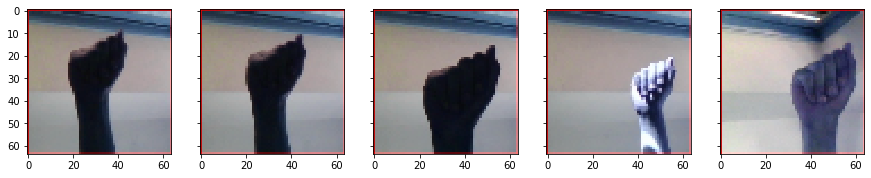

In [40]:
main()